In [ ]:
#Importing Required Libraries
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split, DataLoader, Dataset
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import torch.nn as nn

In [ ]:
torch.__version__

'1.10.0+cu111'

In [ ]:
#Check GPU availability
print(torch.cuda.is_available())
print(torch.cuda.device_count())

True
1


In [ ]:
#Loader for CIFAR10 (From Avenue) with some custom changes
import random
import numpy as np
from PIL import Image
import json
import os


def unpickle(file):
    import _pickle as cPickle
    with open(file, 'rb') as fo:
        dict = cPickle.load(fo, encoding='latin1')
    return dict


class cifar_dataset(Dataset):
    def __init__(self, dataset, root_dir, transform, mode, noise_file=''):

        self.transform = transform
        self.mode = mode
        self.transition = {0: 0, 2: 0, 4: 7, 7: 7, 1: 1, 9: 1, 3: 5, 5: 3, 6: 6,
                           8: 8}  # class transition for asymmetric noise for cifar10
        # generate asymmetric noise for cifar100
        self.transition_cifar100 = {}
        nb_superclasses = 20
        nb_subclasses = 5
        base = [1, 2, 3, 4, 0]
        for i in range(nb_superclasses * nb_subclasses):
            self.transition_cifar100[i] = int(base[i % 5] + 5 * int(i / 5))

        if self.mode == 'test':
            if dataset == 'cifar10':
                test_dic = unpickle('%s/test_batch' % root_dir)
                self.test_data = test_dic['data']
                self.test_data = self.test_data.reshape((10000, 3, 32, 32))
                self.test_data = self.test_data.transpose((0, 2, 3, 1))
                self.test_label = test_dic['labels']
            elif dataset == 'cifar100':
                test_dic = unpickle('%s/test' % root_dir)
                self.test_data = test_dic['data']
                self.test_data = self.test_data.reshape((10000, 3, 32, 32))
                self.test_data = self.test_data.transpose((0, 2, 3, 1))
                self.test_label = test_dic['fine_labels']
        else:
            train_data = []
            train_label = []
            if dataset == 'cifar10':
                for n in range(1, 6):
                    dpath = '%s/data_batch_%d' % (root_dir, n)
                    data_dic = unpickle(dpath)
                    train_data.append(data_dic['data'])
                    train_label = train_label + data_dic['labels']
                train_data = np.concatenate(train_data)
            elif dataset == 'cifar100':
                train_dic = unpickle('%s/train' % root_dir)
                train_data = train_dic['data']
                train_label = train_dic['fine_labels']
                # print(train_label)
                # print(len(train_label))
            train_data = train_data.reshape((50000, 3, 32, 32))
            train_data = train_data.transpose((0, 2, 3, 1))

            noise_label = json.load(open(noise_file, "r"))

            if self.mode == 'train':
                self.train_data = train_data
                self.noise_label = noise_label
                self.clean_label = train_label

    def __getitem__(self, index):
        if self.mode == 'train':
            img, target = self.train_data[index], self.noise_label[index]
            img = Image.fromarray(img)
            img = self.transform(img)
            return img, target, index
        elif self.mode == 'test':
            img, target = self.test_data[index], self.test_label[index]
            img = Image.fromarray(img)
            img = self.transform(img)
            return img, target

    def __len__(self):
        if self.mode != 'test':
            return len(self.train_data)
        else:
            return len(self.test_data)


class cifar_dataloader():
    def __init__(self, dataset, batch_size, num_workers, root_dir, noise_file=''):
        self.dataset = dataset
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.root_dir = root_dir
        self.noise_file = noise_file
        if self.dataset == 'cifar10':
            self.transform_train = transforms.Compose([
                transforms.RandomCrop(32, padding=4),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
            ])
            self.transform_test = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
            ])
        elif self.dataset == 'cifar100':
            self.transform_train = transforms.Compose([
                transforms.RandomCrop(32, padding=4),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize((0.507, 0.487, 0.441), (0.267, 0.256, 0.276)),
            ])
            self.transform_test = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.507, 0.487, 0.441), (0.267, 0.256, 0.276)),
            ])

    def run(self, mode):
        if mode == 'train':
            train_dataset = cifar_dataset(dataset=self.dataset,
                                          root_dir=self.root_dir, transform=self.transform_train, mode="train",
                                          noise_file=self.noise_file)
            trainloader = DataLoader(
                dataset=train_dataset,
                batch_size=self.batch_size,
                shuffle=False,
                num_workers=self.num_workers)
            return trainloader, np.asarray(train_dataset.noise_label), np.asarray(train_dataset.clean_label)

        elif mode == 'test':
            test_dataset = cifar_dataset(dataset=self.dataset,
                                         root_dir=self.root_dir, transform=self.transform_test, mode='test')
            test_loader = DataLoader(
                dataset=test_dataset,
                batch_size=self.batch_size,
                shuffle=False,
                num_workers=self.num_workers)
            return test_loader
 

# test the custom loaders for CIFAR
dataset = 'cifar10'  # either cifar10 or cifar100
data_path = '/content/drive/MyDrive/Noice_Labels_Files'  # path to the data file (don't forget to download the feature data and also put the noisy label file under this folder)
 
loader = cifar_dataloader(dataset, batch_size=650000,
                          num_workers=2,
                          root_dir=data_path,
                          noise_file='%s/cifar10_noisy_labels_task2.json' % (data_path))

In [ ]:
all_trainloader, noisy_labels, clean_labels = loader.run('train')
test_loader = loader.run('test')

In [ ]:
#Validating for the custom loader code
sum((noisy_labels == clean_labels) * 1.0)

14063.0

In [ ]:
labels_from_data = []
for images, labels, *temp in all_trainloader:
  labels_from_data.append(labels)

In [ ]:
labels_from_data[0]

tensor([3, 5, 3,  ..., 7, 1, 7])

In [ ]:
noisy_labels

array([3, 5, 3, ..., 7, 1, 7])

In [ ]:
clean_labels

array([6, 9, 9, ..., 9, 1, 1])

In [ ]:
labels_from_data = labels_from_data[0].tolist()

In [ ]:
sum((labels_from_data == noisy_labels) * 1.0)

50000.0

In [ ]:
len(noisy_labels)

50000

In [ ]:
#Visualize the dataset
def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return (images * stds) + means

def show_preview(dl):
    for images, labels, *temp in dl:
        fig, ax = plt.subplots(figsize = (5, 5))
        #images = denormalize(images, *data_statistics)
        ax.imshow(make_grid(images, 5).permute(1, 2, 0))
        print(labels)
        #print(images.shape, labels)
        break

In [ ]:
#CUDA specific code
def get_default_device():
    return torch.device("cuda") if torch.cuda.is_available() is True else torch.device("cpu")

def to_device(entity, device):
    if isinstance(entity, (list, tuple)):
        return [to_device(element, device) for element in entity]
    return entity.to(device, non_blocking = True)

class DeviceDataLoader():
    def __init__(self, dataloader, device):
        self.dl = dataloader
        self.device = device
    
    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)
    
    def __len__(self):
        return len(self.dl)


device = get_default_device()
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
test_dl = DeviceDataLoader(test_dl, device)

In [ ]:
print("Default device: ", device)

Default device:  cuda


In [ ]:
#Define the underlying conv block
def conv_block(in_channels, out_channels, pooling = False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size = 3, padding = 1),
    nn.BatchNorm2d(out_channels),
    nn.ReLU(inplace = True)]
    
    if pooling:
        layers.append(nn.MaxPool2d(2))
    
    return nn.Sequential(*layers)

In [ ]:
#Define the custom ResNetX model
class ResNetX(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()

        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pooling = True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))

        self.conv3 = conv_block(128, 256, pooling = True)
        self.conv4 = conv_block(256, 512, pooling = True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))

        self.classifier = nn.Sequential(nn.MaxPool2d(4),
                                        nn.Flatten(),
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))
  
    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        return self.classifier(out)

In [ ]:
#Define the evaluation metrics
def accuracy(logits, labels):
    pred, predClassId = torch.max(logits, dim = 1)
    return torch.tensor(torch.sum(predClassId == labels).item() / len(logits))

def evaluate(model, dl, loss_func):
  model.eval()
  batch_losses, batch_accs = [], []
  for images, labels, *temp in dl:
      with torch.no_grad():
          logits = model(images)
      batch_losses.append(loss_func(logits, labels))
      batch_accs.append(accuracy(logits, labels))
  epoch_avg_loss = torch.stack(batch_losses).mean().item()
  epoch_avg_acc = torch.stack(batch_accs).mean().item()
  return epoch_avg_loss, epoch_avg_acc

In [ ]:
#Define training method
def train(model, train_dl, val_dl, epochs, max_lr, loss_func, optim):
    optimizer = optim(model.parameters(), max_lr)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs * len(train_dl))
    
    results = []
    
    for epoch in range(epochs):
        model.train()
        train_losses = []
        lrs = []
        for images, labels, *temp in train_dl:
            logits = model(images)
            loss = loss_func(logits, labels)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            lrs.append(optimizer.param_groups[0]["lr"])
            scheduler.step()
        epoch_train_loss = torch.stack(train_losses).mean().item()
        
        epoch_avg_loss, epoch_avg_acc = evaluate(model, val_dl, loss_func)
        print("Epoch: ", epoch, " Avg_valid_loss: ", epoch_avg_loss, " Avg_valid_acc: ", epoch_avg_acc, " Avg_train_loss: ", epoch_train_loss)
        results.append({"avg_valid_loss": epoch_avg_loss, "avg_valid_acc": epoch_avg_acc, "avg_train_loss": epoch_train_loss})

    return results

In [ ]:
#Define the model parameters
model = ResNetX(3, 10)
model = to_device(model, device)
epochs = 10
max_lr = 1e-2
loss_func = nn.functional.cross_entropy
optim = torch.optim.Adam

In [ ]:
#Training the model
%%time
results = train(model, train_dl, val_dl, epochs, max_lr, loss_func, optim)

Epoch:  0  Avg_valid_loss:  2.1971774101257324  Avg_valid_acc:  0.23742012679576874  Avg_train_loss:  2.31889009475708
Epoch:  1  Avg_valid_loss:  2.0363516807556152  Avg_valid_acc:  0.32018768787384033  Avg_train_loss:  2.157763957977295
Epoch:  2  Avg_valid_loss:  1.9768993854522705  Avg_valid_acc:  0.36601439118385315  Avg_train_loss:  2.0054869651794434
Epoch:  3  Avg_valid_loss:  1.9189213514328003  Avg_valid_acc:  0.3937699794769287  Avg_train_loss:  1.9450265169143677
Epoch:  4  Avg_valid_loss:  1.8908072710037231  Avg_valid_acc:  0.40505191683769226  Avg_train_loss:  1.8950566053390503
Epoch:  5  Avg_valid_loss:  1.8176913261413574  Avg_valid_acc:  0.46305909752845764  Avg_train_loss:  1.8467284440994263
Epoch:  6  Avg_valid_loss:  1.9320470094680786  Avg_valid_acc:  0.3855830729007721  Avg_train_loss:  1.797473430633545
Epoch:  7  Avg_valid_loss:  1.732795238494873  Avg_valid_acc:  0.5012979507446289  Avg_train_loss:  1.7428483963012695
Epoch:  8  Avg_valid_loss:  1.7030415534

In [ ]:
results

[{'avg_train_loss': 2.31889009475708,
  'avg_valid_acc': 0.23742012679576874,
  'avg_valid_loss': 2.1971774101257324},
 {'avg_train_loss': 2.157763957977295,
  'avg_valid_acc': 0.32018768787384033,
  'avg_valid_loss': 2.0363516807556152},
 {'avg_train_loss': 2.0054869651794434,
  'avg_valid_acc': 0.36601439118385315,
  'avg_valid_loss': 1.9768993854522705},
 {'avg_train_loss': 1.9450265169143677,
  'avg_valid_acc': 0.3937699794769287,
  'avg_valid_loss': 1.9189213514328003},
 {'avg_train_loss': 1.8950566053390503,
  'avg_valid_acc': 0.40505191683769226,
  'avg_valid_loss': 1.8908072710037231},
 {'avg_train_loss': 1.8467284440994263,
  'avg_valid_acc': 0.46305909752845764,
  'avg_valid_loss': 1.8176913261413574},
 {'avg_train_loss': 1.797473430633545,
  'avg_valid_acc': 0.3855830729007721,
  'avg_valid_loss': 1.9320470094680786},
 {'avg_train_loss': 1.7428483963012695,
  'avg_valid_acc': 0.5012979507446289,
  'avg_valid_loss': 1.732795238494873},
 {'avg_train_loss': 1.6911511421203613,


In [ ]:
for result in results:
  print(result["avg_train_loss"])

2.31889009475708
2.157763957977295
2.0054869651794434
1.9450265169143677
1.8950566053390503
1.8467284440994263
1.797473430633545
1.7428483963012695
1.6911511421203613
1.6623891592025757


In [ ]:
#Evaluate the model on testing data
_, test_acc = evaluate(model, test_dl, loss_func)
print(test_acc)

0.8027156591415405


In [ ]:
#Saving the model and then loading the model for verification
torch.save(model.state_dict(), "cifar-10-ResNetX.pth")
model_2 = ResNetX(3, 10)
model_2 = to_device(model_2, device)
_, test_acc_model_2 = evaluate(model_2, test_dl, loss_func)
print(test_acc_model_2 )
model_2.load_state_dict(torch.load("cifar-10-ResNetX.pth"))
_, test_acc_model_2_after_loading = evaluate(model_2, test_dl, loss_func)
print(test_acc_model_2_after_loading )

tensor(0.0857)
tensor(0.9097)


In [ ]:
def plot(results, pairs):
  fig, axes = plt.subplots(len(pairs), figsize = (10, 10))
  for i, pair in enumerate(pairs):
    for title, graphs in pair.items():
      for graph in graphs:
        axes[i].set_title(title)
        axes[i].plot([result[graph] for result in results], "r")

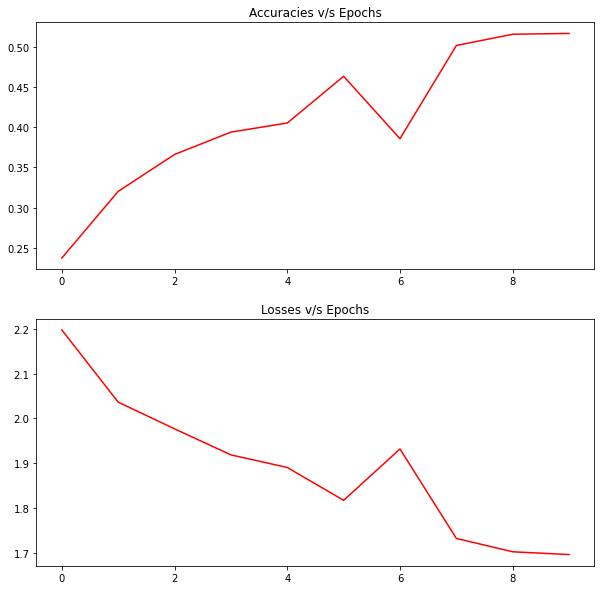

In [ ]:
plot(results, [{"Accuracies v/s Epochs": ["avg_valid_acc"]}, {"Losses v/s Epochs": ["avg_valid_loss"]}])